In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Chicago data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

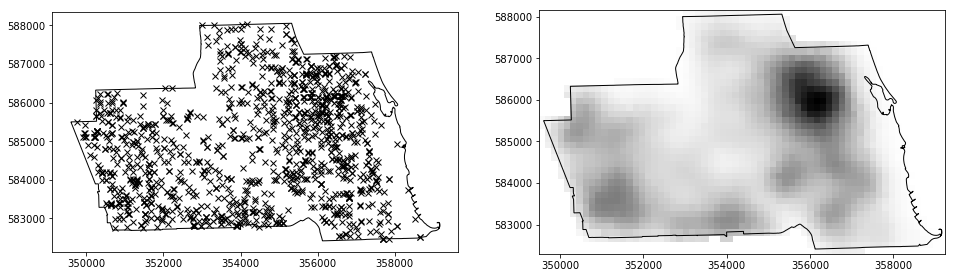

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*_pred.mesh_data(), _pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Train

In [8]:
trainer = sepp.sepp_grid_space.Trainer1(grid, 5)
trainer.data = points

model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model1(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.2788111807807254, omega=0.006540465717558264, alpha=0.008194134856471545, sigma^2=44.30719727884875, r0=5

In [9]:
1 / model.omega

152.89431107565341

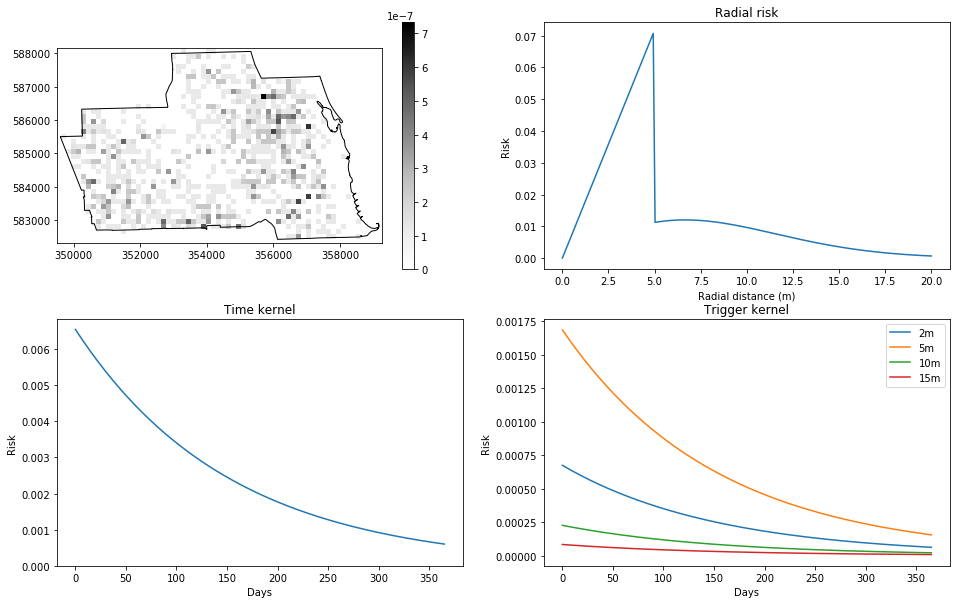

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))
axes = axes.flatten()

pred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

ax = axes[1]
x = np.linspace(0, 20, 200)
y = x * 0
y[x <= model.r0] = model.alpha
m = x > model.r0
y[m] = np.exp(-x[m]**2/(2*model.sigmasq)) * model.beta
y =  y * x * 2 * np.pi
ax.plot(x, y * model.theta)
ax.set(ylabel="Risk", xlabel="Radial distance (m)")
ax.set_title("Radial risk")

ax = axes[2]
x = np.linspace(0, 365, 200)
y = model.omega * np.exp(-x * model.omega)
ax.plot(x, y)
ymax = ax.get_ylim()[1]
ax.set(xlabel="Days", ylabel="Risk", ylim=[0,ymax], title="Time kernel")

dists = [2, 5, 10, 15]
ax = axes[3]
for d in dists:
    if d <= model.r0:
        dy = model.alpha
    else:
        dy = np.exp(-d**2/(2*model.sigmasq)) * model.beta
    dy *= d * 2 * np.pi
    ax.plot(x, dy * y, label="{}m".format(d))
ax.set(xlabel="Days", ylabel="Risk", title="Trigger kernel")
ax.legend()
None

In [11]:
np.sum(model.mu * grid.xsize * grid.ysize)

2.769115979479825

Thinking about how to better visualise what this data tells us.

Here we try to integrate over the trigger kernel to get curves in just time.

But then it occurred to me that to make use of this, we need to know what events occurred in the past.

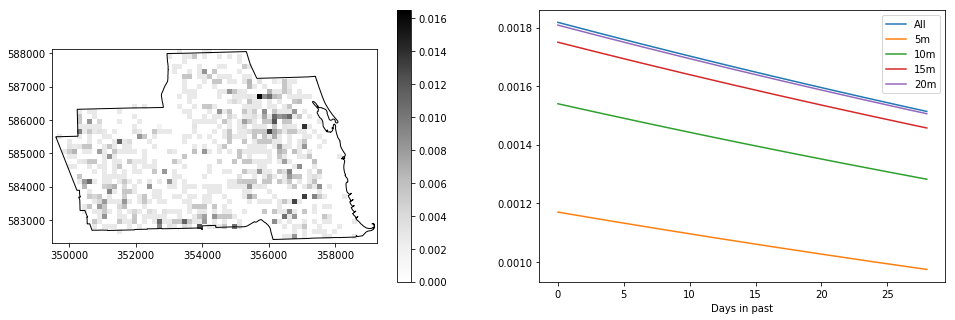

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

pred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix * grid.xsize * grid.ysize, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

ax = axes[1]
x = np.linspace(0, 28, 200)
y = model.theta * np.exp(-model.omega * x) * (1 - np.exp(-model.omega))
ax.plot(x, y, label="All")
for d in [5, 10, 15, 20]:
    ax.plot(x, y * model.space_trigger_mass(d), label="{}m".format(d))
ax.set(xlabel="Days in past")
ax.legend()
None

Take a sample of triggers and backgrounds: this agrees with our intuition that the space trigger is very constrained in space.

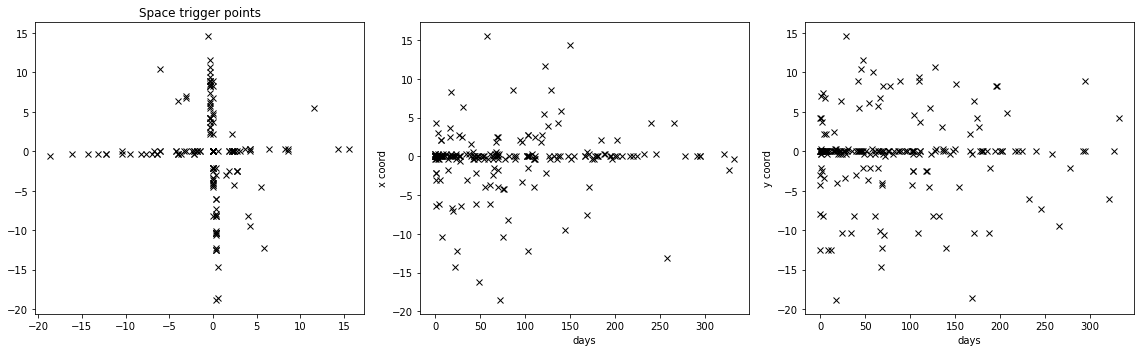

In [13]:
backgrounds, trigger_deltas = trainer.sample_to_points(model, datetime.datetime(2017,1,1))

fig, axes = plt.subplots(ncols=3, figsize=(16,5))
ax = axes[0]
ax.scatter(*trigger_deltas[1:], marker="x", color="black", linewidth=1)
ax.set_title("Space trigger points")
ax = axes[1]
ax.scatter(*trigger_deltas[[0,1]], marker="x", color="black", linewidth=1)
ax.set(xlabel="days", ylabel="x coord")
ax = axes[2]
ax.scatter(*trigger_deltas[[0,2]], marker="x", color="black", linewidth=1)
ax.set(xlabel="days", ylabel="y coord")

fig.tight_layout()

So instead actually make a prediction, as that before combines at different bits of data.

In [14]:
predictor = trainer.to_predictor(model)
predictor.data = trainer.data
pred1 = predictor.predict(datetime.datetime(2017,1,1))
pred2 = predictor.predict(datetime.datetime(2016,9,1))
pred3 = predictor.predict(datetime.datetime(2016,10,15))

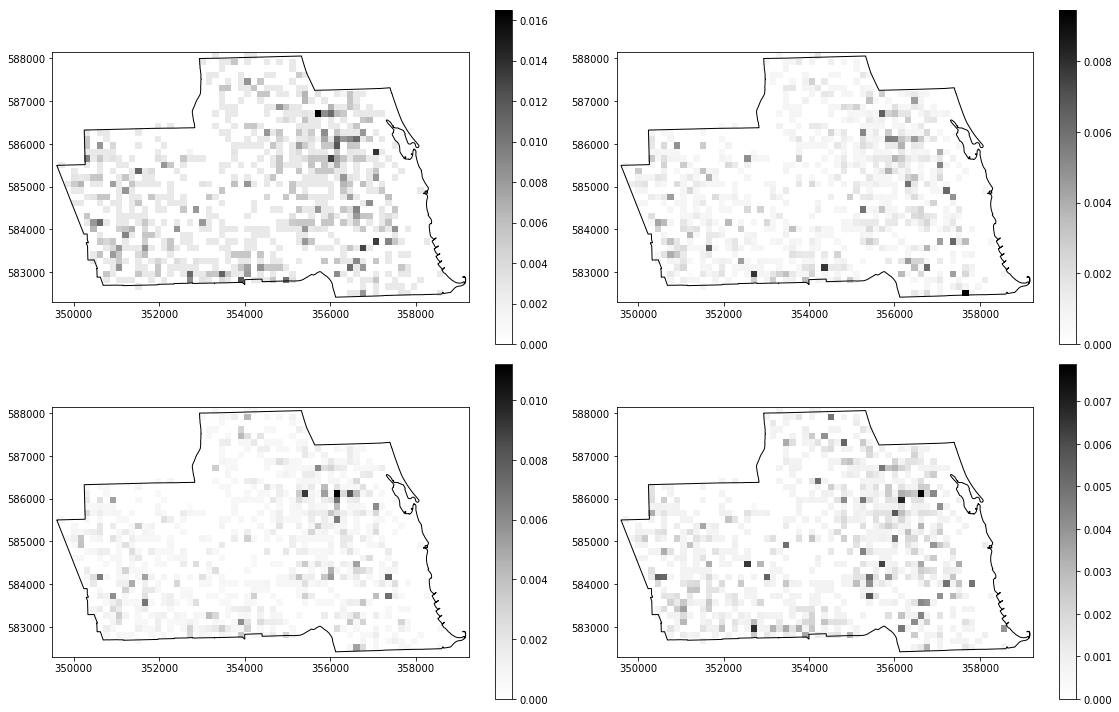

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

for ax in axes.flat:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
   
bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
ax = axes[0][0]
m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix * grid.xsize * grid.ysize, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)

for ax, pred in zip(axes.flatten()[1:], [pred1, pred2, pred3]):
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

fig.tight_layout()

## How does this change with $r_0$?

In [16]:
r0_range = np.exp(np.linspace(0, np.log(500), 100))
models = {}
for r0 in r0_range:
    trainer = sepp.sepp_grid_space.Trainer1(grid, r0)
    trainer.data = points
    models[r0] = trainer.train(datetime.datetime(2017,1,1), iterations=40)

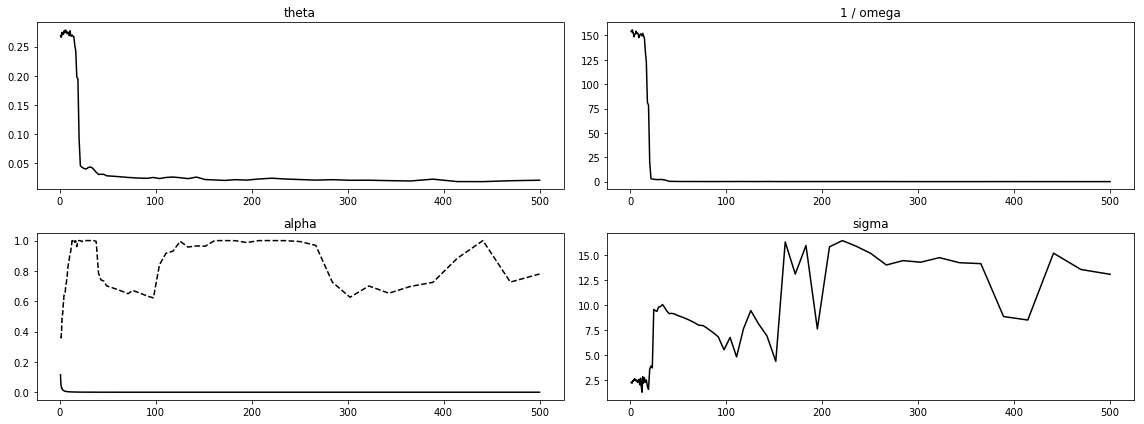

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,6))

axes = axes.flatten()

axes[0].plot(r0_range, [models[r].theta for r in r0_range], color="black")
axes[0].set(title="theta")
axes[1].plot(r0_range, [1/models[r].omega for r in r0_range], color="black")
axes[1].set(title="1 / omega")
axes[2].plot(r0_range, [models[r].alpha for r in r0_range], color="black")
axes[2].plot(r0_range, [models[r].alpha*r*r*np.pi for r in r0_range], color="black", linestyle="--")
axes[2].set(title="alpha")
axes[3].plot(r0_range, [np.sqrt(models[r].sigma) for r in r0_range], color="black")
axes[3].set(title="sigma")

fig.tight_layout()
fig.savefig("../varying_r0.pdf")